## NBA GM Signings Analysis - Part 2

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import requests
import time
import json
from bs4 import BeautifulSoup

In [3]:
years = list(range(2022,2025))

### Pulling in Saved Data from Basketball Reference

In [4]:
winshares_df = pd.read_csv('C:/Users/kevin/Downloads/win shares stats 2022-2024.csv')

### Combine with Google Sheet Data

In [5]:
signings_df = pd.read_csv('C:/Users/kevin/Downloads/NBA GM Transaction Dataset - ALL TEAMS Signing Data 2022-2024.csv')

### Merging Data

In [6]:
merged_df = pd.merge(signings_df, winshares_df[['Player', 'Year', 'Tm', 'WS']], 
                     left_on=['Acquired Player', 'Season', 'Team Acquiring'], 
                     right_on=['Player', 'Year', 'Tm'], 
                     how='left')

In [7]:
signings_df['Acquired Player Win Shares Year 1'] = merged_df['WS']

In [8]:
merged_df_year2 = pd.merge(signings_df, winshares_df[['Player', 'Year', 'Tm', 'WS']], 
                     left_on=['Acquired Player', 'Year 2', 'Team Acquiring'], 
                     right_on=['Player', 'Year', 'Tm'], 
                     how='left')

In [9]:
signings_df['Acquired Player Win Shares Year 2'] = merged_df_year2['WS']

In [10]:
signings_df.isna().sum()

Season                                 0
Team Acquiring                         0
Acquired Player                        0
Team Losing                            1
Acquisition Type                       0
Acquiring GM                           0
Losing GM                             13
Year 2                                 0
Helper                                 0
AAV                                    0
One Year?                              0
Acquired Player Win Shares Year 1     35
Acquired Player Win Shares Year 2    168
dtype: int64

In [11]:
signings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Season                             201 non-null    int64  
 1   Team Acquiring                     201 non-null    object 
 2   Acquired Player                    201 non-null    object 
 3   Team Losing                        200 non-null    object 
 4   Acquisition Type                   201 non-null    object 
 5   Acquiring GM                       201 non-null    object 
 6   Losing GM                          188 non-null    object 
 7   Year 2                             201 non-null    int64  
 8   Helper                             201 non-null    object 
 9   AAV                                201 non-null    float64
 10  One Year?                          201 non-null    object 
 11  Acquired Player Win Shares Year 1  166 non-null    object 

From here it looks most players (168/201) in this dataset did not stay on the same team in year 2 after the acquisition.

In [12]:
signings_df[signings_df['Acquired Player'] == 'Lauri Markkanen']

,Season,Team Acquiring,Acquired Player,Team Losing,Acquisition Type,Acquiring GM,Losing GM,Year 2,Helper,AAV,One Year?,Acquired Player Win Shares Year 1,Acquired Player Win Shares Year 2
121,2022,CLE,Lauri Markkanen,CHI,Signing,Koby Altman,Marc Eversley,2023,2022Lauri Markkanen,16.75,No,5.0,NaN


In [13]:
winshares_df[winshares_df['Player'] == 'Lauri Markkanen']

,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,...,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Year
490,Lauri Markkanen,SF,24,CLE,61,1878,14.7,.582,.541,.226,...,19.5,2.7,2.3,5.0,.127,0.4,-0.1,0.4,1.1,2022
1249,Lauri Markkanen,PF,25,UTA,66,2273,22.1,.640,.446,.348,...,26.6,6.3,1.9,8.2,.173,4.9,-1.0,3.8,3.3,2023
1967,Lauri Markkanen,PF,26,UTA,55,1820,21.5,.631,.493,.311,...,25.0,5.2,0.9,6.2,.163,5.1,-1.5,3.6,2.6,2024


In [14]:
signings_df[signings_df['Acquired Player'] == 'Jalen Brunson']

,Season,Team Acquiring,Acquired Player,Team Losing,Acquisition Type,Acquiring GM,Losing GM,Year 2,Helper,AAV,One Year?,Acquired Player Win Shares Year 1,Acquired Player Win Shares Year 2
151,2023,NYK,Jalen Brunson,DAL,Signing,Scott Perry,Nico Harrison,2024,2023Jalen Brunson,26.0,No,8.7,11.2


In [15]:
winshares_df[winshares_df['Player'] == 'Jalen Brunson']

,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,...,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Year
102,Jalen Brunson,SG,25,DAL,79,2524,17.1,.583,.250,.211,...,21.9,4.9,2.7,7.5,.143,0.9,0.0,0.9,1.9,2022
937,Jalen Brunson,PG,26,NYK,68,2379,21.2,.597,.269,.328,...,27.2,6.9,1.8,8.7,.175,4.4,-0.5,3.9,3.5,2023
1659,Jalen Brunson,PG,27,NYK,77,2726,23.4,.592,.319,.302,...,32.5,8.8,2.4,11.2,.198,6.3,-0.4,5.8,5.4,2024


The two examples shows that our Acquired Player BPM/WARP Year 2 calculation only pulls in if the player stayed with the team that acquired them in the second year. This is what we want - if they no longer have the player, the value they brought on doesn't help.

## Aggregation and Visualization

### Cost per Win Share

In [10]:
# Convert 'AAV' and 'Acquired Player BPM/WARP Year 1' to numeric, coercing errors to NaN
signings_df['AAV'] = pd.to_numeric(signings_df['AAV'], errors='coerce')
signings_df['Acquired Player Win Shares Year 1'] = pd.to_numeric(signings_df['Acquired Player Win Shares Year 1'], errors='coerce')

# Group by 'Acquiring GM' and 'Team Acquiring', then calculate the sum and count
grouped_year1 = signings_df.groupby(['Acquiring GM', 'Team Acquiring']).agg({
    'AAV': 'sum',
    'Acquired Player Win Shares Year 1': 'sum',
    'Acquiring GM': 'count'  # Using 'count' to get the number of entries per group
})

# Rename the count column for clarity
grouped_year1 = grouped_year1.rename(columns={'Acquiring GM': 'Count'})

# Calculate the ratio of AAV to Acquired Player BPM/WARP Year 1
grouped_year1['Cost of Win Share'] = grouped_year1['AAV'] / grouped_year1['Acquired Player Win Shares Year 1']

# Reset index for easier plotting
grouped_year1 = grouped_year1.reset_index()

In [11]:
grouped_year1 = grouped_year1.rename(columns={'AAV': 'AAV_sum'})

In [41]:
grouped_year1

,Acquiring GM,Team Acquiring,AAV_sum,Acquired Player Win Shares Year 1,Count,Cost of Win Share
0,Andy Elisburg,MIA,48.62,15.4,5,3.157143
1,Anthony Parker,ORL,11.00,2.6,1,4.230769
2,Bob Myers,GSW,13.91,4.6,4,3.023913
3,Bobby Webster,TOR,29.89,-0.5,8,-59.780000
4,Brad Stevens,BOS,29.90,4.2,10,7.119048
5,Brian Wright,SAS,31.30,4.9,6,6.387755
6,Calvin Booth,DEN,23.40,13.5,6,1.733333
7,Chad Buchanan,IND,34.08,4.7,5,7.251064
8,Daryl Morey,PHI,31.22,14.1,9,2.214184
9,James Jones,PHO,26.10,18.4,10,1.418478


In [22]:
grouped_year1.to_csv('C:/Users/kevin/Downloads/first year acquired NBA players win shares GM aggregation.csv')

### Adding in Modeling Component - What Should the Cost of 1 Win Share Be?

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [24]:
grouped_year1.columns

Index(['Acquiring GM', 'Team Acquiring', 'AAV_sum',
       'Acquired Player Win Shares Year 1', 'Count', 'Cost of Win Share'],
      dtype='object')

In [25]:
features = grouped_year1['AAV_sum'].values.reshape(-1, 1)
target = grouped_year1['Acquired Player Win Shares Year 1']

In [26]:
lm = LinearRegression()
lm.fit(features,target)

LinearRegression()

In [27]:
coeff_df = pd.DataFrame(lm.coef_,index=['AAV_sum'],columns=['Coefficient'])
coeff_df

,Coefficient
AAV_sum,0.262287


In [28]:
cost_win_share_modeled = 1 / coeff_df['Coefficient'].iloc[0]
cost_win_share_modeled

3.81262326578587

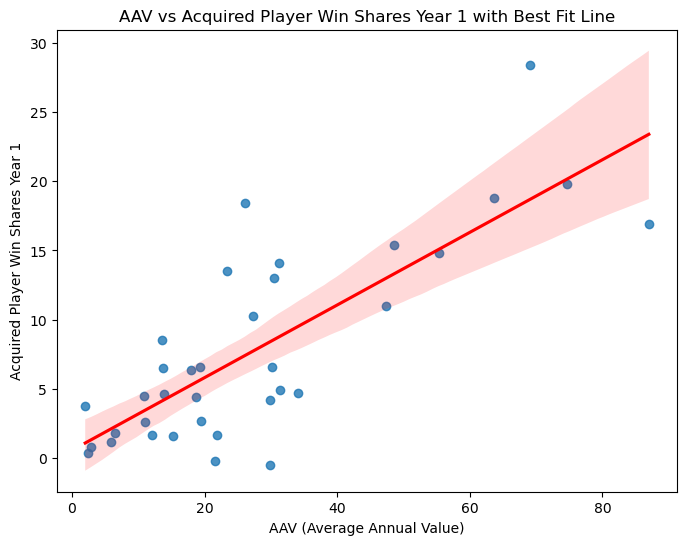

In [30]:
# Scatter plot with line of best fit
plt.figure(figsize=(8,6))
sns.regplot(x='AAV_sum', y='Acquired Player Win Shares Year 1', data=grouped_year1, line_kws={"color": "red"})

# Adding labels and title
plt.xlabel('AAV (Average Annual Value)')
plt.ylabel('Acquired Player Win Shares Year 1')
plt.title('AAV vs Acquired Player Win Shares Year 1 with Best Fit Line')

# Show plot
plt.show()

The regression yields a cost per win share of $3.81 million. The raw calculation below is used to just gut check that number.

In [14]:
aav_sum = grouped_year1['AAV_sum'].sum()
win_shares_sum = grouped_year1['Acquired Player Win Shares Year 1'].sum()

cost_win_share_raw = aav_sum / win_shares_sum
print(cost_win_share_raw)

3.5356699525374227


In [42]:

# Group by 'Acquiring GM' and 'Team Acquiring', then calculate the sum and count
grouped_year1_by_season = signings_df.groupby(['Season', 'Acquiring GM', 'Team Acquiring']).agg({
    'AAV': 'sum',
    'Acquired Player Win Shares Year 1': 'sum',
    'Acquiring GM': 'count'  # Using 'count' to get the number of entries per group
})

# Rename the count column for clarity
grouped_year1_by_season = grouped_year1_by_season.rename(columns={'Acquiring GM': 'Count'})

# Calculate the ratio of AAV to Acquired Player BPM/WARP Year 1
grouped_year1_by_season['Cost of Win Share'] = grouped_year1_by_season['AAV'] / grouped_year1_by_season['Acquired Player Win Shares Year 1']

# Reset index for easier plotting
grouped_year1_by_season = grouped_year1_by_season.reset_index()

In [44]:
grouped_year1_by_season = grouped_year1_by_season.rename(columns={'AAV': 'AAV_sum'})

In [45]:
# Group by 'Season' and calculate the sum of 'AAV' and 'Acquired Player Win Shares Year 1' for each season
grouped_by_season = grouped_year1_by_season.groupby('Season').agg({
    'AAV_sum': 'sum',
    'Acquired Player Win Shares Year 1': 'sum'
})

# Calculate cost per win share for each season
grouped_by_season['Cost Per Win Share'] = grouped_by_season['AAV_sum'] / grouped_by_season['Acquired Player Win Shares Year 1']

print(grouped_by_season[['Cost Per Win Share']])

        Cost Per Win Share
Season                    
2022              3.410081
2023              3.240366
2024              3.999746


Recreating the cost per win share plot from earlier with a line for the average cost per win share as a reference.

In [54]:
import matplotlib.image as mpimg
from PIL import Image

In [50]:
grouped_year1['Team Acquiring'].unique()

array(['MIA', 'ORL', 'GSW', 'TOR', 'BOS', 'SAS', 'DEN', 'IND', 'PHI',
       'PHO', 'POR', 'MIL', 'UTA', 'CLE', 'ATL', 'NYK', 'CHI', 'LAC',
       'CHO', 'SAC', 'DAL', 'HOU', 'LAL', 'OKC', 'BRK', 'MIN', 'WAS',
       'NOP', 'DET', 'MEM'], dtype=object)

C:\Users\kevin\AppData\Local\Temp\ipykernel_8636\2777922476.py:42: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((90, 44), Image.ANTIALIAS)  # Increased size to 90x44


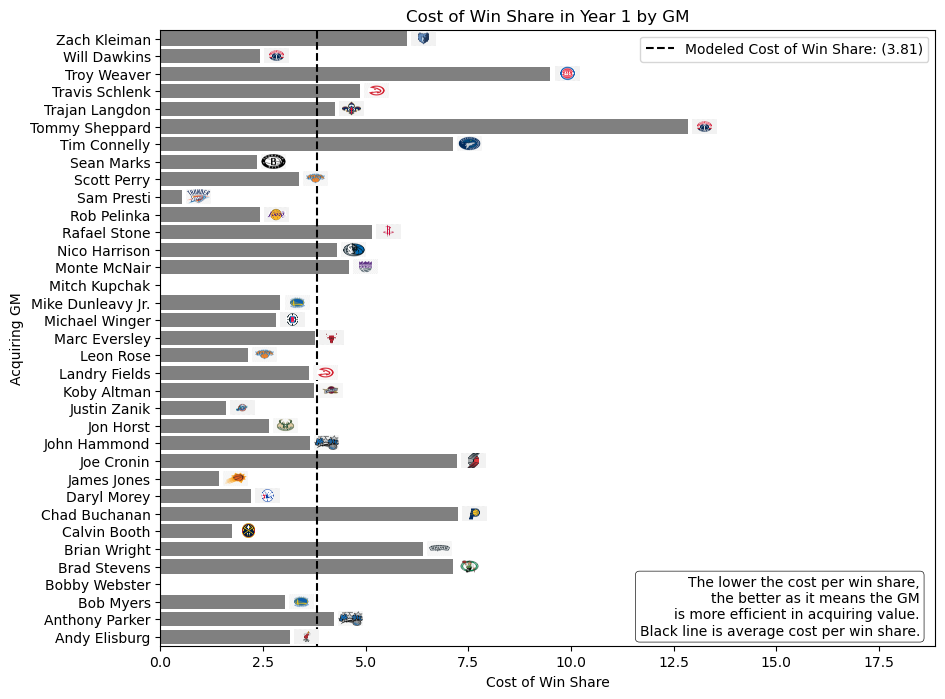

In [61]:
# Set up the plot size with reduced height
plt.figure(figsize=(10, 8))  # Adjust the height here

# Create a horizontal bar chart using seaborn
sns.barplot(y='Acquiring GM', x='Cost of Win Share', data=grouped_year1, color='gray')

# Add labels and title
plt.title('Cost of Win Share in Year 1 by GM')
plt.xlabel('Cost of Win Share')
plt.ylabel('Acquiring GM')

# Set the x-axis limits to show only positive values
plt.xlim(0, plt.xlim()[1])  # Lower limit is set to 0, upper limit remains unchanged

# Set the y-axis limits to keep bars within a certain height
plt.ylim(-0.5, len(grouped_year1) - 0.5)  # Adjust y-axis limits to fit the number of bars

# Add a black reference line for the modeled cost of a win share
plt.axvline(x=cost_win_share_modeled, color='black', linestyle='--', label=f'Modeled Cost of Win Share: ({cost_win_share_modeled:.2f})')

# Add an annotation with a multi-line text box aligned to the far right
plt.text(
    x=plt.xlim()[1] * 0.98,  # Position near the far right of the x-axis
    y=len(grouped_year1) * 0.1,  # Adjusted vertical position
    s="The lower the cost per win share,\nthe better as it means the GM\nis more efficient in acquiring value.\nBlack line is average cost per win share.",
    ha='right',  # Align text to the right
    va='top',  # Vertical alignment to the top
    color='black',
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white", linewidth=0.5, alpha=0.9),
)

# Add larger team logos to the right of each bar
for i, (index, row) in enumerate(grouped_year1.iterrows()):
    team_name = row['Team Acquiring']  # Assuming 'Team Acquiring' has the team names
    logo_path = f'C:/Users/kevin/Downloads/logos/{team_name}.png'  # Update with actual path to logos
    
    # Load the logo image
    img = Image.open(logo_path)
    
    # Resize the image (width, height) - 100% larger than previous size
    img = img.resize((90, 44), Image.ANTIALIAS)  # Increased size to 90x44
    img = mpimg.imread(logo_path)  # Convert back to numpy array after resizing
    
    # Set the position for the logo to the right of each bar
    plt.imshow(img, aspect='auto', extent=[row['Cost of Win Share'] + 0.1, row['Cost of Win Share'] + 0.7, 
                                            i - 0.4, i + 0.4], zorder=5)

# Rotate y-axis labels for better readability if needed (optional)
plt.yticks(rotation=0)

# Add a legend for the reference line
plt.legend()

# Show the plot
plt.show()

In [15]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = grouped_year1['Cost of Win Share'].quantile(0.25)
Q3 = grouped_year1['Cost of Win Share'].quantile(0.75)
IQR = Q3 - Q1  # Interquartile Range

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers from the DataFrame
filtered_df = grouped_year1[(grouped_year1['Cost of Win Share'] >= lower_bound) & 
                             (grouped_year1['Cost of Win Share'] <= upper_bound)]

std_cost = filtered_df['Cost of Win Share'].std()

In [63]:
std_cost

1.8479760346033192

In [64]:
cost_win_share_modeled

3.81262326578587

In [65]:
# Define a grading function
def assign_grade(cost):
    if cost < 0:
        return 'F'
    elif cost >= cost_win_share_modeled - std_cost * 0.5 and cost <= cost_win_share_modeled + std_cost * 0.5:
        return 'C'
    elif cost > cost_win_share_modeled - std_cost and cost <= cost_win_share_modeled - std_cost * 0.5:
        return 'B'
    elif cost < cost_win_share_modeled - std_cost:
        return 'A'
    elif cost > cost_win_share_modeled + std_cost * 0.5 and cost <= cost_win_share_modeled + std_cost * 2:
        return 'D'
    elif cost > cost_win_share_modeled + std_cost * 2:
        return 'F'

# Apply the grading function to the 'Cost of Win Share' column and create a new 'Grade' column
grouped_year1['Grade'] = grouped_year1['Cost of Win Share'].apply(assign_grade)

In [66]:
grouped_year1.sort_values(by='Grade')

,Acquiring GM,Team Acquiring,AAV_sum,Acquired Player Win Shares Year 1,Count,Cost of Win Share,Grade
13,Justin Zanik,UTA,13.57,8.5,4,1.596471,A
25,Sam Presti,OKC,2.00,3.8,1,0.526316,A
9,James Jones,PHO,26.10,18.4,10,1.418478,A
6,Calvin Booth,DEN,23.40,13.5,6,1.733333,A
8,Daryl Morey,PHI,31.22,14.1,9,2.214184,B
18,Michael Winger,LAC,17.95,6.4,3,2.804688,B
12,Jon Horst,MIL,27.24,10.3,7,2.644660,B
33,Will Dawkins,WAS,10.90,4.5,2,2.422222,B
16,Leon Rose,NYK,13.80,6.5,2,2.123077,B
24,Rob Pelinka,LAL,69.00,28.4,24,2.429577,B


<Axes: xlabel='AAV_sum', ylabel='Cost of Win Share'>

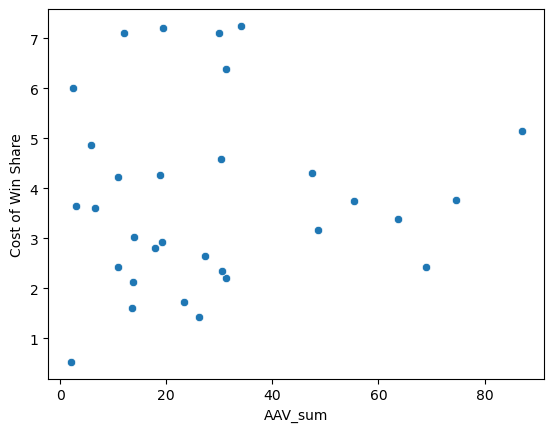

In [16]:
sns.scatterplot(data=filtered_df, x="AAV_sum", y="Cost of Win Share")

In [17]:
filtered_df["AAV_sum"].corr(filtered_df["Cost of Win Share"])

0.059085998177396036

### Ratio of Players Signed to Players Lost

In [67]:
signings_df.columns

Index(['Season', 'Team Acquiring', 'Acquired Player', 'Team Losing',
       'Acquisition Type', 'Acquiring GM', 'Losing GM', 'Year 2', 'Helper',
       'AAV', 'One Year?', 'Acquired Player Win Shares Year 1',
       'Acquired Player Win Shares Year 2'],
      dtype='object')

In [68]:
filtered_df = signings_df.copy()

# Convert 'AAV' and 'Acquired Player BPM/WARP Year 1' to numeric, coercing errors to NaN
filtered_df['AAV'] = pd.to_numeric(filtered_df['AAV'], errors='coerce')
filtered_df['Acquired Player Win Shares Year 1'] = pd.to_numeric(filtered_df['Acquired Player Win Shares Year 1'], errors='coerce')

# Group by 'Team Acquiring' and calculate the sum of 'AAV' and 'Acquired Player BPM/WARP Year 1'
grouped_against = filtered_df.groupby('Losing GM').agg({
    'AAV': 'sum',
    'Acquired Player Win Shares Year 1': 'sum'
})

# Calculate the ratio of AAV to Acquired Player BPM/WARP Year 1
grouped_against['Cost of Win Share'] = grouped_against['AAV'] / grouped_against['Acquired Player Win Shares Year 1']

# Reset index for easier plotting
grouped_against = grouped_against.reset_index()

In [69]:
grouped_against

,Losing GM,AAV,Acquired Player Win Shares Year 1,Cost of Win Share
0,Andy Elisburg,58.98,13.3,4.434586
1,Anthony Parker,2.50,1.6,1.562500
2,Bob Myers,16.44,0.9,18.266667
3,Bobby Webster,83.54,19.7,4.240609
4,Brad Stevens,44.25,6.9,6.413043
5,Brian Wright,54.05,17.8,3.036517
6,Calvin Booth,57.50,16.6,3.463855
7,Chad Buchanan,18.65,4.1,4.548780
8,Daryl Morey,29.82,13.0,2.293846
9,James Jones,26.46,9.1,2.907692


In [70]:
signings_df[signings_df['Losing GM'] == 'Rob Pelinka']

,Season,Team Acquiring,Acquired Player,Team Losing,Acquisition Type,Acquiring GM,Losing GM,Year 2,Helper,AAV,One Year?,Acquired Player Win Shares Year 1,Acquired Player Win Shares Year 2
0,2022,PHI,Andre Drummond,LAL,Signing,Daryl Morey,Rob Pelinka,2023,2022Andre Drummond,2.40,Yes,2.9,NaN
6,2022,POR,Ben McLemore,LAL,Signing,Joe Cronin,Rob Pelinka,2023,2022Ben McLemore,2.40,Yes,0.8,NaN
8,2022,MIA,Markieff Morris,LAL,Signing,Andy Elisburg,Rob Pelinka,2023,2022Markieff Morris,2.60,Yes,0.3,NaN
14,2022,BOS,Dennis Schroder,LAL,Signing,Brad Stevens,Rob Pelinka,2023,2022Dennis Schroder,5.90,Yes,NaN,NaN
37,2024,MIL,Malik Beasley,LAL,Signing,Jon Horst,Rob Pelinka,2025,2024Malik Beasley,2.70,Yes,3.5,NaN
43,2024,MIN,Troy Brown,LAL,Signing,Tim Connelly,Rob Pelinka,2025,2024Troy Brown,1.90,Yes,NaN,NaN
44,2024,PHI,Mo Bamba,LAL,Signing,Daryl Morey,Rob Pelinka,2025,2024Mo Bamba,1.90,Yes,2.0,NaN
46,2024,BRK,Lonnie Walker IV,LAL,Signing,Sean Marks,Rob Pelinka,2025,2024Lonnie Walker IV,2.40,Yes,0.8,NaN
57,2022,CHI,Alex Caruso,LAL,Signing,Marc Eversley,Rob Pelinka,2023,2022Alex Caruso,9.25,No,2.0,3.6
64,2023,SAC,Malik Monk,LAL,Signing,Monte McNair,Rob Pelinka,2024,2023Malik Monk,9.70,No,3.2,3.5


In [73]:
# Merge the two DataFrames on 'Team Acquiring' and 'Team Losing'
grouped_difference = pd.merge(grouped_year1, grouped_against, 
                              left_on='Acquiring GM', right_on='Losing GM', 
                              suffixes=('_acquired', '_losing'))

# Calculate the final ratio by dividing the AAV_to_WS of acquired over the AAV_to_WS of losing
grouped_difference['final_ratio'] = grouped_difference['Cost of Win Share_losing'] / grouped_difference['Cost of Win Share_acquired']

# Select only the relevant columns for the result
grouped_difference = grouped_difference[['Team Acquiring','Acquiring GM', 'final_ratio']]

In interpreting these values, above a ratio above 1 means that a team is more efficient with the players they bring in versus the players they lose.

C:\Users\kevin\AppData\Local\Temp\ipykernel_8636\883865642.py:42: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((90, 44), Image.ANTIALIAS)  # Increased size to 90x44
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


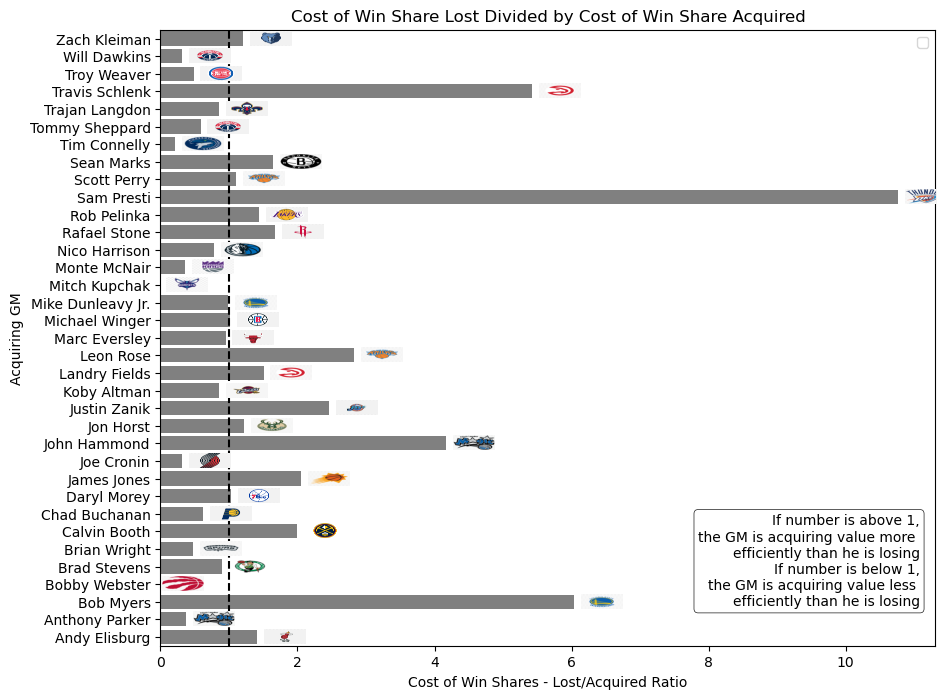

In [79]:
# Set up the plot size with reduced height
plt.figure(figsize=(10, 8))  # Adjust the height here

# Create a horizontal bar chart using seaborn
sns.barplot(y='Acquiring GM', x='final_ratio', data=grouped_difference, color='gray')

# Add labels and title
plt.title('Cost of Win Share Lost Divided by Cost of Win Share Acquired')
plt.xlabel('Cost of Win Shares - Lost/Acquired Ratio')
plt.ylabel('Acquiring GM')

# Set the x-axis limits to show only positive values
plt.xlim(0, plt.xlim()[1])  # Lower limit is set to 0, upper limit remains unchanged

# Set the y-axis limits to keep bars within a certain height
plt.ylim(-0.5, len(grouped_difference) - 0.5)  # Adjust y-axis limits to fit the number of bars

# Add a black reference line for the modeled cost of a win share
plt.axvline(x=1, color='black', linestyle='--')

# Add an annotation with a multi-line text box aligned to the far right
plt.text(
    x=plt.xlim()[1] * 0.98,  # Position near the far right of the x-axis
    y=len(grouped_difference) * 0.2,  # Adjusted vertical position
    s="If number is above 1,\nthe GM is acquiring value more \nefficiently than he is losing\nIf number is below 1,\nthe GM is acquiring value less \nefficiently than he is losing",
    ha='right',  # Align text to the right
    va='top',  # Vertical alignment to the top
    color='black',
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white", linewidth=0.5, alpha=0.9),
)

# Add larger team logos to the right of each bar
for i, (index, row) in enumerate(grouped_difference.iterrows()):
    team_name = row['Team Acquiring']  # Assuming 'Team Acquiring' has the team names
    logo_path = f'C:/Users/kevin/Downloads/logos/{team_name}.png'  # Update with actual path to logos
    
    # Load the logo image
    img = Image.open(logo_path)
    
    # Resize the image (width, height) - 100% larger than previous size
    img = img.resize((90, 44), Image.ANTIALIAS)  # Increased size to 90x44
    img = mpimg.imread(logo_path)  # Convert back to numpy array after resizing
    
    # Set the position for the logo to the right of each bar
    plt.imshow(img, aspect='auto', extent=[row['final_ratio'] + 0.1, row['final_ratio'] + 0.7, 
                                            i - 0.4, i + 0.4], zorder=5)

# Rotate y-axis labels for better readability if needed (optional)
plt.yticks(rotation=0)

# Add a legend for the reference line
plt.legend()

# Show the plot
plt.show()

In [80]:
grouped_difference[grouped_difference['Acquiring GM'] == 'Jon Horst']

,Team Acquiring,Acquiring GM,final_ratio
12,MIL,Jon Horst,1.216505


In [81]:
grouped_year1[grouped_year1['Acquiring GM'] == 'Jon Horst']

,Acquiring GM,Team Acquiring,AAV_sum,Acquired Player Win Shares Year 1,Count,Cost of Win Share,Grade
12,Jon Horst,MIL,27.24,10.3,7,2.64466,B


In [82]:
grouped_against[grouped_against['Losing GM'] == 'Jon Horst']

,Losing GM,AAV,Acquired Player Win Shares Year 1,Cost of Win Share
12,Jon Horst,27.99,8.7,3.217241


Using Jon Horst as a way to validate this final ratio with the cost of win shares acquired and lost in respective tables.

In [83]:
grouped_difference.to_csv('C:/Users/kevin/Downloads/first year lost win shares dived by acquired win shares GM aggregation.csv')